In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-1-and-2/AQI_ex.csv
/kaggle/input/dataset-1-and-2/seoul_ex.csv


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

In [3]:
# Function to load and preprocess the data, including date extraction
def load_and_preprocess_data_with_dates(file_path, sequence_length=60):
    # Load data and separate Date column
    data = pd.read_csv(file_path)
    dates = data['Date'].values  # Extract Date column
    data = data.iloc[:, 1:]  # Drop the Date column for scaling
    
    # Convert non-numeric columns and scale features
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna()
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    X, y, sequence_dates = [], [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(data_scaled[i])
        sequence_dates.append(dates[i])  # Track dates for each sequence end

    return np.array(X), np.array(y), sequence_dates, scaler

# Load and preprocess the data
file_path = '/kaggle/input/dataset-1-and-2/AQI_ex.csv'  # Adjust path as needed
sequence_length = 60
X_aqi, y_aqi, sequence_dates, scaler_aqi = load_and_preprocess_data_with_dates(file_path, sequence_length)


In [4]:
# Define LSTM model
def create_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(output_dim))  # Ensure output shape matches y dimension
    return model

input_shape = (X_aqi.shape[1], X_aqi.shape[2])
output_dim = y_aqi.shape[1]
model_custom = create_model(input_shape, output_dim)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Define Custom Loss Function with Dynamic Smoothness
class CustomLossV3(tf.keras.losses.Loss):
    def __init__(self, initial_smoothness_weight=0.01, alpha=0.5):
        super().__init__()
        self.smoothness_weight = initial_smoothness_weight
        self.alpha = alpha  # Weight for combining MAE and MSE

    def call(self, y_true, y_pred):
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        combined_error = self.alpha * mae + (1 - self.alpha) * mse

        smoothness_penalty = 0
        if y_pred.shape[1] > 2:
            moving_avg_diff = tf.reduce_mean(
                tf.square(y_pred[:, 2:] - (y_pred[:, 1:-1] + y_pred[:, :-2]) / 2)
            )
            smoothness_penalty = moving_avg_diff

        adaptive_weight = self.smoothness_weight * tf.exp(-0.001 * self.smoothness_weight)
        total_loss = combined_error + adaptive_weight * smoothness_penalty

        self.smoothness_weight += 0.005
        return total_loss

custom_loss = CustomLossV3()

In [6]:
# Train and plot results with custom loss function
def train_and_evaluate_with_plot(model, X, y, loss_function, loss_name, sequence_dates, scaler, epochs=50, batch_size=32):
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print(f"The accuracy using {loss_name} - MAE: {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{loss_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Inverse transform predicted and actual values for plotting
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_true_rescaled = scaler.inverse_transform(y)

    # Plot Predicted vs True AQI with Date
    plt.figure(figsize=(14, 7))
    plt.plot(sequence_dates, y_true_rescaled[:, -1], label='True AQI', color='blue')
    plt.plot(sequence_dates, y_pred_rescaled[:, -1], label='Predicted AQI', color='red', linestyle='dashed')
    plt.title(f'True vs Predicted AQI with {loss_name}')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()
    
    return [mae,mse,rmse,r2]

Training with Custom Loss...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0513 - mae: 0.0862
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0378 - mae: 0.0649
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0369 - mae: 0.0635
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0364 - mae: 0.0626
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0359 - mae: 0.0618
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0354 - mae: 0.0610
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0348 - mae: 0.0602
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0343 - mae: 0.0593
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337 - mae: 0.0585
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329 - mae: 0.0570
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321 - mae: 0.0558
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - mae: 0.0550
Epoch 13/50
40/40 ━━

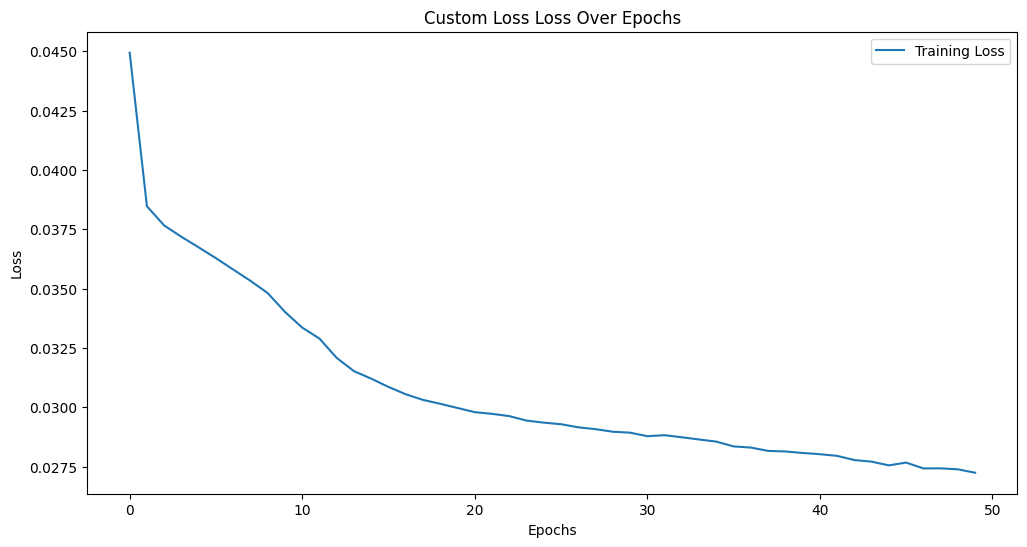

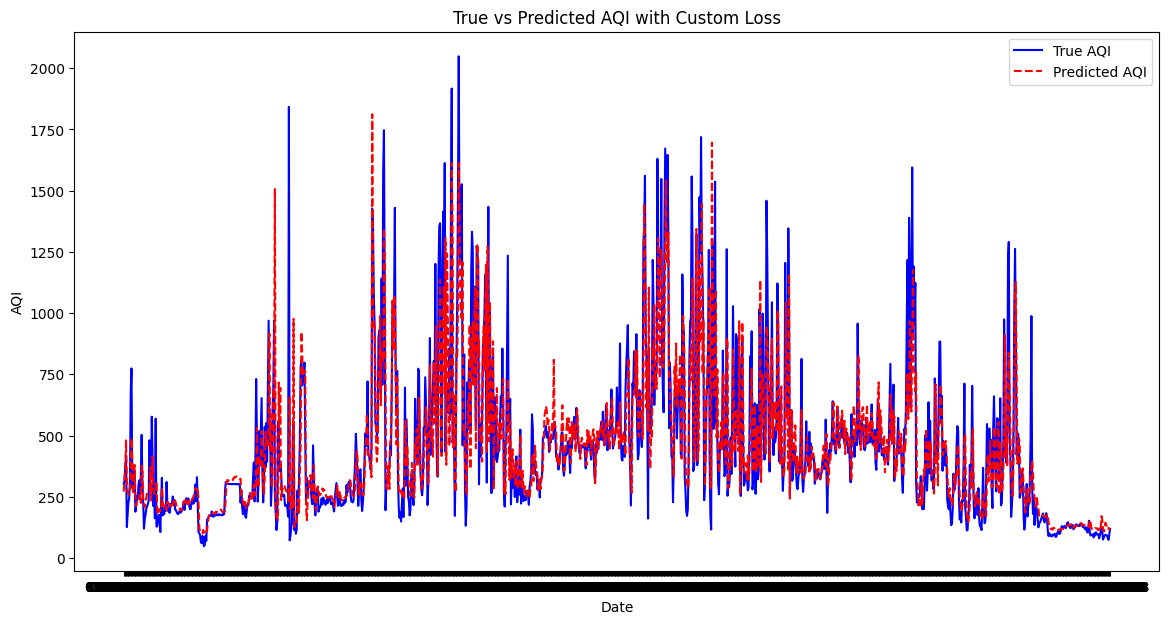

In [7]:
# Training and plotting with custom loss
print("Training with Custom Loss...")
[mae_custom,mse_custom,rmse_custom,r2_custom] = train_and_evaluate_with_plot(model_custom, X_aqi, y_aqi, custom_loss, "Custom Loss", sequence_dates, scaler_aqi, epochs=50)
model_custom.save("model_custom_loss.h5")  # Save the model with custom loss

Training with MSE Loss...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0201 - mae: 0.0991
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mae: 0.0708
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - mae: 0.0678
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mae: 0.0667
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mae: 0.0656
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mae: 0.0644
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mae: 0.0632
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mae: 0.0618
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mae: 0.0605
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mae: 0.0592
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - mae: 0.0581
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - mae: 0.0572
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

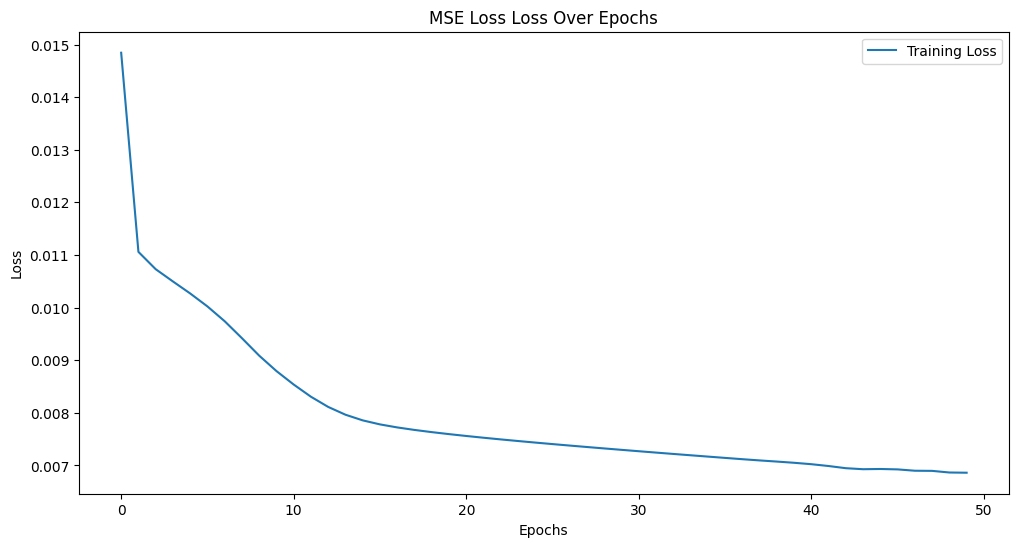

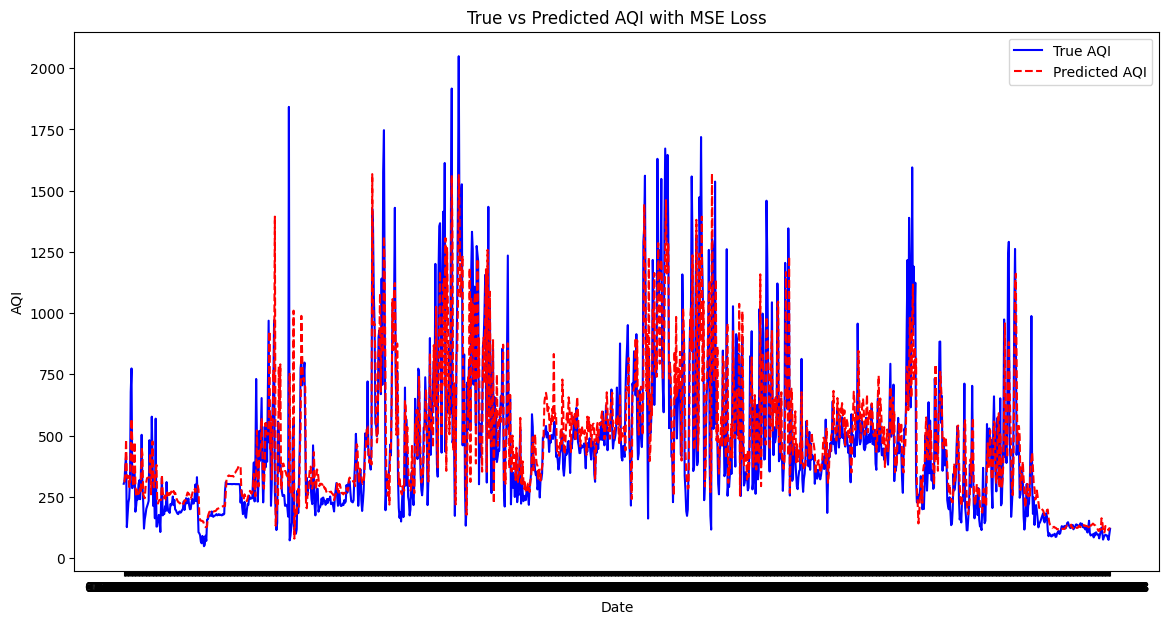

In [8]:
# Recreate model for MSE to ensure independent training
model_mse = create_model(input_shape, output_dim)

# Training and plotting with MSE loss
print("Training with MSE Loss...")
[mae_mse, mse_mse, rmse_mse, r2_mse] = train_and_evaluate_with_plot(model_mse, X_aqi, y_aqi, "mse", "MSE Loss", sequence_dates, scaler_aqi, epochs=50)
model_mse.save("model_mse_loss.h5")  # Save the model with MSE loss

Training with MAE Loss...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1014 - mae: 0.1014
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0648 - mae: 0.0648
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0634 - mae: 0.0634
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0624 - mae: 0.0624
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0615 - mae: 0.0615
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0608 - mae: 0.0608
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0596 - mae: 0.0596
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0585 - mae: 0.0585
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0569 - mae: 0.0569
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0560 - mae: 0.0560
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0550 - mae: 0.0550
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0540 - mae: 0.0540
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

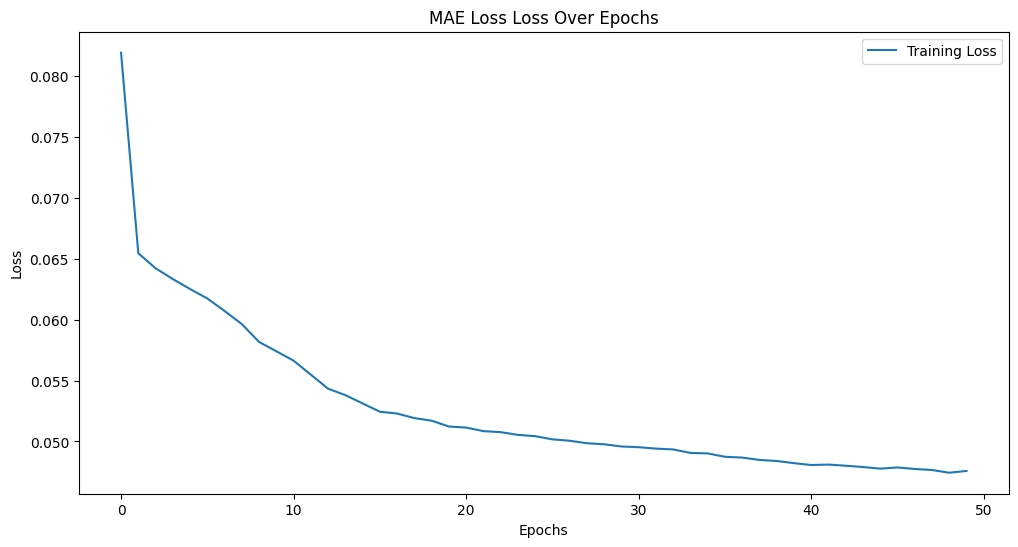

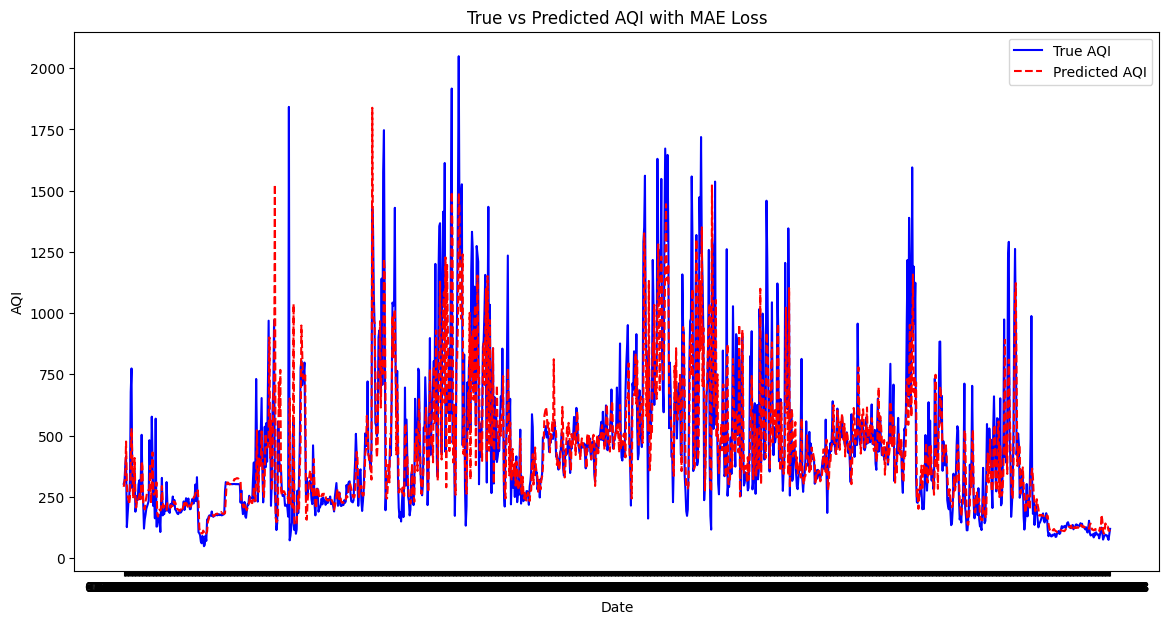

In [9]:
# Recreate model for MSE to ensure independent training
model_mae = create_model(input_shape, output_dim)

# Training and plotting with MAE loss
print("Training with MAE Loss...")
[mae_mae, mse_mae, rmse_mae, r2_mae] = train_and_evaluate_with_plot(model_mae, X_aqi, y_aqi, "mae", "MAE Loss", sequence_dates, scaler_aqi, epochs=50)
model_mae.save("model_mae_loss.h5")  # Save the model with MAE loss


Training with Huber Loss...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0099 - mae: 0.0976
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0697
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mae: 0.0679
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mae: 0.0669
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mae: 0.0659
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0650
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mae: 0.0639
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0628
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0615
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mae: 0.0603
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0591
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0581
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

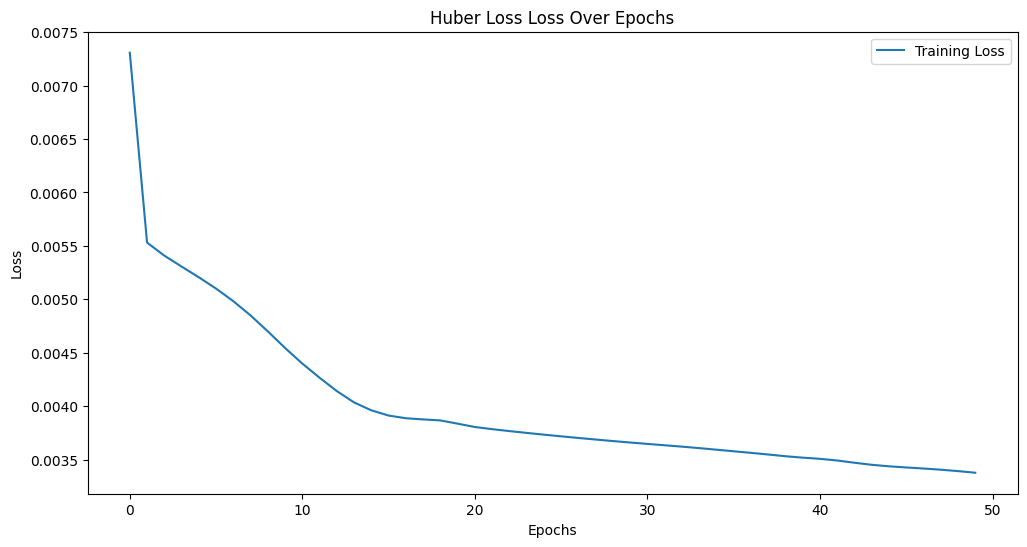

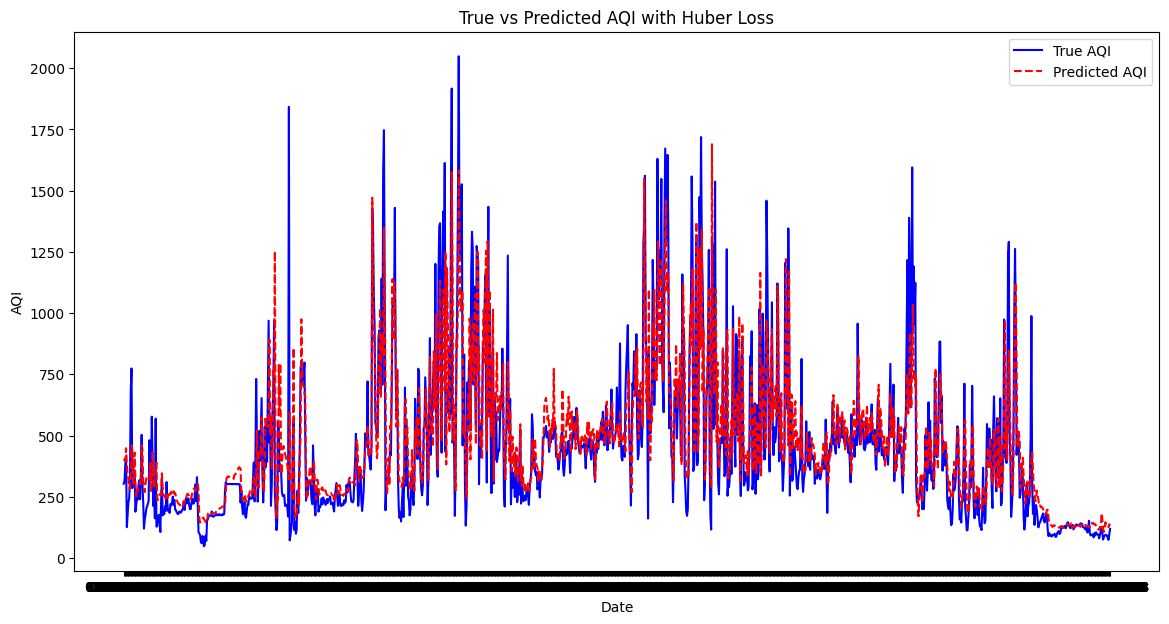

In [10]:
# Recreate model for Huber loss to ensure independent training
model_huber = create_model(input_shape, output_dim)

# Training and plotting with Huber loss
print("Training with Huber Loss...")
[mae_huber, mse_huber, rmse_huber, r2_huber] = train_and_evaluate_with_plot(model_huber, X_aqi, y_aqi, "huber", "Huber Loss", sequence_dates, scaler_aqi, epochs=50)
model_huber.save("model_huber_loss.h5")  # Save the model with Huber loss

In [11]:
# Compare Results

print("\nComparison of MAE for Loss Functions:")
print(f"The accuracy using Custom Loss - MAE: {mae_custom:.4f}")
print(f"The accuracy using MSE Loss - MAE: {mae_mse:.4f}")
print(f"The accuracy using MAE Loss - MAE: {mae_mae:.4f}")
print(f"The accuracy using Huber Loss - MAE: {mae_huber:.4f}")

print("\nComparison of MSE for Loss Functions:")
print(f"The accuracy using Custom Loss - MSE: {mse_custom:.4f}")
print(f"The accuracy using MSE Loss - MSE: {mse_mse:.4f}")
print(f"The accuracy using MAE Loss - MSE: {mse_mae:.4f}")
print(f"The accuracy using Huber Loss - MSE: {mse_huber:.4f}")

print("\nComparison of RMSE for Loss Functions:")
print(f"The accuracy using Custom Loss - RMSE: {rmse_custom:.4f}")
print(f"The accuracy using MSE Loss - RMSE: {rmse_mse:.4f}")
print(f"The accuracy using MAE Loss - RMSE: {rmse_mae:.4f}")
print(f"The accuracy using Huber Loss - RMSE: {rmse_huber:.4f}")

print("\nComparison of R2 for Loss Functions:")
print(f"The accuracy using Custom Loss - R2: {r2_custom:.4f}")
print(f"The accuracy using MSE Loss - R2: {r2_mse:.4f}")
print(f"The accuracy using MAE Loss - R2: {r2_mae:.4f}")
print(f"The accuracy using Huber Loss - R2: {r2_huber:.4f}")


Comparison of MAE for Loss Functions:
The accuracy using Custom Loss - MAE: 0.0464
The accuracy using MSE Loss - MAE: 0.0511
The accuracy using MAE Loss - MAE: 0.0466
The accuracy using Huber Loss - MAE: 0.0505

Comparison of MSE for Loss Functions:
The accuracy using Custom Loss - MSE: 0.0068
The accuracy using MSE Loss - MSE: 0.0066
The accuracy using MAE Loss - MSE: 0.0070
The accuracy using Huber Loss - MSE: 0.0065

Comparison of RMSE for Loss Functions:
The accuracy using Custom Loss - RMSE: 0.0824
The accuracy using MSE Loss - RMSE: 0.0813
The accuracy using MAE Loss - RMSE: 0.0838
The accuracy using Huber Loss - RMSE: 0.0805

Comparison of R2 for Loss Functions:
The accuracy using Custom Loss - R2: 0.5571
The accuracy using MSE Loss - R2: 0.5697
The accuracy using MAE Loss - R2: 0.5404
The accuracy using Huber Loss - R2: 0.5770
